# SQD （サンプルベースの量子対角化）によるフェルミオン ハミルトニアンのエネルギー推定の改善

*Estimated QPU usage: 36 seconds (tested on IBM Sherbrooke)*

Based on [the tutorial at IBM Quantum Learning](https://learning.quantum.ibm.com/tutorial/improving-energy-estimation-of-a-fermionic-hamiltonian-with-sqd).

## 背景

このチュートリアルでは、ノイズを含む量子サンプルを後処理して、平衡結合長における窒素分子 $\text{N}_2$ の基底状態を近似的に求める方法を説明します。これには、36量子ビット（32システム量子ビット + 4補助量子ビット）を使用した量子回路から得られたサンプルを基に、サンプルベースの量子対角化（SQD）アルゴリズム([sample-based quantum diagonalization (SQD) algorithm](https://arxiv.org/abs/2405.05068))を使用します。Qiskitをベースとした実装が[Qiskit Addons](https://github.com/Qiskit/qiskit-addon-sqd)として提供されており、[簡単な例](https://docs.quantum.ibm.com/guides/qiskit-addons-sqd-get-started) を含む詳細は[docs](https://docs.quantum.ibm.com/guides/qiskit-addons-sqd)で確認できます。SQDは、量子系のハミルトニアンのような量子演算子の固有値と固有ベクトルを、量子計算と分散型古典計算を組み合わせて求める手法です。分散型古典計算は、量子プロセッサーから得られたサンプルを処理し、それらが張る部分空間でターゲットのハミルトニアンを射影および対角化するために使用されます。この手法により、SQDは量子ノイズで破損したサンプルに対する堅牢性を確保するとともに、数百万の相互作用項を持つ化学ハミルトニアンのような大規模なハミルトニアンを、正確な対角化方法の範囲を超えて処理することが可能になります。SQDを用いたワークフローは、以下の手順で構成されます：

1. 回路のアンザッツ（仮定形）を選び、それを量子コンピューター上で基準状態（この場合、[Hartree-Fock](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method)状態）に適用する。
2. 得られた量子状態からビット列をサンプリングする。
3. ビット列に対して*セルフコンシステントな配置復元*手順を実行し、基底状態の近似を得る。

### 量子化学

分子の性質は主に、その中の電子構造によって決まります。フェルミ粒子である電子は、第二量子化と呼ばれる数学的形式を用いて記述できます。この概念では、いくつかの*軌道*が存在し、それぞれが空（未占有）またはフェルミオンによって占有されている状態のいずれかとなります。 $N$ 個の軌道からなる系は、フェルミオン消滅演算子 $\{\hat{a}_p\}_{p=1}^N$ の集合によって記述され、これらは次のようなフェルミオンの反交換関係を満たします。

$$
\begin{align*}
\hat{a}_p \hat{a}_q + \hat{a}_q \hat{a}_p &= 0, \\
\hat{a}_p \hat{a}_q^\dagger + \hat{a}_q^\dagger \hat{a}_p &= \delta_{pq}.
\end{align*}
$$

随伴演算子 $\hat{a}_p^\dagger$ は生成演算子と呼ばれます。

これまでの説明では、フェルミオンの基本的な性質であるスピンを考慮していませんでした。スピンを考慮すると、軌道は*空間軌道*と呼ばれるペアで現れます。各空間軌道は2つの*スピン軌道*から構成され、1つは "spin-$\alpha$" 、もう1つは "spin-$\beta$" とラベル付けされます。この場合、空間軌道 $p$ のスピン軌道でスピン $\sigma$ ($\sigma \in \{\alpha, \beta\}$) に対応する消滅演算子を $\hat{a}_{p\sigma}$ と表記します。空間軌道の数を $N$ とすると、スピン軌道は合計で $2N$ 存在します。この系のヒルベルト空間は、次のような2部ビット列でラベル付けされた $2^{2N}$ 個の正規直交基底ベクトルによって張られます：$\lvert z \rangle = \lvert z_\beta z_\alpha \rangle = \lvert z_{\beta, N} \cdots z_{\beta, 1} z_{\alpha, N} \cdots z_{\alpha, 1} \rangle$

分子の系のハミルトニアンは次のように書かれます：

$$
\hat{H} = \sum_{ \substack{pr\\\sigma} } h_{pr} \, \hat{a}^\dagger_{p\sigma} \hat{a}_{r\sigma}
+ \frac12
\sum_{ \substack{prqs\\\sigma\tau} }
h_{prqs} \, 
\hat{a}^\dagger_{p\sigma}
\hat{a}^\dagger_{q\tau}
\hat{a}_{s\tau}
\hat{a}_{r\sigma},
$$

ここで、$h_{pr}$ および $h_{prqs}$ は分子積分と呼ばれる複素数で、分子の仕様に基づいてコンピュータープログラムを使用して計算することができます。このチュートリアルでは、[PySCF](https://pyscf.org/) ソフトウェアパッケージを使用して積分を計算します。

分子ハミルトニアンの導出方法に関する詳細は、量子化学の教科書（例：SzaboとOstlundによる *Modern Quantum Chemistry*）を参照してください。量子化学の問題を量子コンピューターにマッピングする方法についてのハイレベルな説明は、Qiskit Global Summer School 2024 の講義 [*Mapping Problems to Qubits*](https://youtu.be/TyFU6r8uEsE?t=900) をご覧ください。

### ローカル・ユニタリー・クラスター・ジャストロウ（LUCJ）アンザッツ

SQDでは、サンプルを取得するための量子回路アンザッツが必要です。このチュートリアルでは、物理的動機付けとハードウェアへの適合性を兼ね備えた[ローカル・ユニタリー・クラスター・ジャストロウ（LUCJ）](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k)アンザッツを使用します。

LUCJアンザッツは、一般的なユニタリー・クラスター・ジャストロウ（UCJ）アンザッツの特殊な形式であり、その一般的な形は次のようになります。
$$
  \lvert \Psi \rangle = \prod_{\mu=1}^L e^{\hat{K}_\mu} e^{i \hat{J}_\mu} e^{-\hat{K}_\mu} | \Phi_0 \rangle
$$

ここで、$\lvert \Phi_0 \rangle$ は基準状態を表し、通常はHartree-Fock状態が選ばれます。 $\hat{K}_\mu$ と $\hat{J}_\mu$ は次の形式を持ちます。

$$
\hat{K}_\mu = \sum_{pq, \sigma} K_{pq}^\mu \, \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{q \sigma}
\;,\;
\hat{J}_\mu = \sum_{pq, \sigma\tau} J_{pq,\sigma\tau}^\mu \, \hat{n}_{p \sigma} \hat{n}_{q \tau}
\;,
$$

ここで、数演算子を次のように定義します。

$$
\hat{n}_{p \sigma} = \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{p \sigma}.
$$

演算子 $e^{\hat{K}_\mu}$ は軌道回転を表し、既知のアルゴリズムを使用して線形の深さで線形の接続で実装することができます。  
一方、UCJアンザッツの $e^{i \mathcal{J}_k}$ 項を実装するには、全対全（all-to-all）の接続性が必要になるか、フェルミオンスワップネットワークを使用する必要があります。そのため、接続性が制限されたノイズありで誤り耐性実現前の量子プロセッサーにとっては実装困難となります。 *ローカル* UCJアンザッツのアイデアは、$\mathbf{J}^{\alpha\alpha}$ 行列と $\mathbf{J}^{\alpha\beta}$ 行列にスパース性の制約を課すことで、接続性が制限された量子ビットトポロジー上でこれらを一定の深さで実装できるようにすることです。この制約は、上三角行列で非ゼロを許可する要素を指定するインデックスのリストによって定義されます（行列が対称であるため、上三角部分のみを指定すれば十分です）。これらのインデックスは、相互作用が許可される軌道のペアとして解釈できます。

例として、正方格子の量子ビットトポロジーを考えます。この場合、$\alpha$ および $\beta$ 軌道を格子上の平行な線上に配置し、これらの線の間を接続して「梯子」の形を形成する「横木（rungs）」を作ることができます。以下のようなイメージです：

![square\_lattice\_gray\_150dpi.png](https://learning-api.quantum.ibm.com/assets/8d33f54f-51c4-42c0-8cb6-c9449d53ca2b)

この構成では、同じスピンを持つ軌道は線形トポロジーで接続され、異なるスピンを持つ軌道は同じ空間軌道を共有している場合に接続されます。この結果、$\mathbf{J}$  行列に対して次のインデックス制約が得られます：

$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \set{(p, p+1) \; , \; p = 0, \ldots, N-2} \\
\mathbf{J}^{\alpha\beta} &: \set{(p, p) \;, \; p = 0, \ldots, N-1}
\end{align*}
$$

言い換えれば、 $\mathbf{J}$ 行列が上三角部分で指定されたインデックスのみで非ゼロであれば、 $e^{i \mathcal{J}_k}$ 項はスワップゲートを使用せず、一定の深さで正方形トポロジー上に実装できます。もちろん、アンザッツにこのような制約を課すと表現力が低下するため、より多くのアンザッツの繰り返しが必要になる場合があります。

IBMのハードウェアはヘビーヘクス格子の量子ビットトポロジーを持っており、この場合「ジグザグ」パターンを採用できます。下に示すように、このパターンでは、同じスピンを持つ軌道が量子ビットにマッピングされ、線形トポロジー（赤と青の円）となります。また、異なるスピンを持つ軌道の接続は、4番目の空間軌道ごとに存在し、その接続は補助量子ビット（紫の円）を介して行われます。この場合、インデックス制約は次のようになります：


$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \set{(p, p+1) \; , \; p = 0, \ldots, N-2} \\
\mathbf{J}^{\alpha\beta} &: \set{(p, p) \;, \; p = 0, 4, 8, \ldots (p \leq N-1)}
\end{align*}
$$

![lucj\_ansatz\_zig\_zag\_pattern.jpg](https://learning-api.quantum.ibm.com/assets/bbe59805-f2aa-4d34-97ca-aa7200442802)

### サンプルベースの量子対角化（SQD）

セルフコンシステントな配置復元手続きは、ノイズの多い量子サンプルからできるだけ多くの信号を抽出することを目的としています。分子ハミルトニアンは粒子数とスピンZを保存するため、これらの対称性も保存する回路アンザッツを選ぶことが理にかなっています。Hartree-Fock状態にこのアンザッツを適用すると、結果として得られる状態はノイズのない設定では、常に一定の粒子数とスピンZを持ちます。したがって、この状態からサンプリングされた任意のビット列のスピン-$\alpha$とスピン-$\beta$の部分は、Hartree-Fock状態と同じ[ハミング重み](https://en.wikipedia.org/wiki/Hamming_weight)を持つべきです。現在の量子プロセッサーにはノイズが存在するため、測定されたビット列のうち一部は、この性質を満たさないことがあります。単純な事後選択手法では、これらのビット列を廃棄することになりますが、これは無駄です。なぜなら、それらのビット列にはまだ信号が含まれている可能性があるからです。セルフコンシステントな置復元手続きは、後処理でその信号の一部を回復しようとします。この手続きは反復的で、入力として基底状態における各軌道の平均占有数の推定値が必要であり、これは最初に生のサンプルから計算されます。手続きはループで実行され、各反復には以下のステップがあります：

1. 指定された対称性を満たさない各ビット列について、そのビットを確率的な手続きで反転させ、ビット列を現在の平均軌道占有数の推定値に近づけて、新しいビット列を得る。
2. 対称性を満たす古いビット列と新しいビット列をすべて集め、事前に選ばれた固定サイズのサブセットをサンプリングする。
3. 各ビット列サブセットに対して、ハミルトニアンを対応する基底ベクトルによって張られる部分空間に射影し（これらの基底ベクトルの説明については[前のセクション](#quantum-chemistry)を参照）、古典コンピューターで射影されたハミルトニアンの基底状態推定を計算する。
4. 最も低いエネルギーを持つ基底状態推定を使用して、平均軌道占有数の推定値を更新する。

SQDのワークフローは、以下の図に示されています：

![sqd\_diagram.png](https://learning-api.quantum.ibm.com/assets/66d73999-337f-442d-956d-7bf0913d53f6)

SQDは、ターゲットの固有状態がスパース（疎）である場合にうまく機能することが知られています。すなわち、波動関数は基底状態の集合 $\mathcal{S} = \{|x\rangle \}$ にサポートされ、そのサイズは問題のサイズに対して指数関数的に増加しません。

## 必要条件

このチュートリアルを始める前に、以下のものがインストールされていることを確認してください：

* Qiskit SDK 1.0 or later with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)
* Qiskit Addons SQD (`pip install qiskit-addon-sqd`)
* ffsim (`pip install ffsim`)


## Step 1: 古典的入力を量子問題にマップする

このチュートリアルでは、6-31G基底セットで平衡状態の分子の基底状態の近似を求めます。最初に、分子とその性質を指定します。

In [ ]:
import pyscf
import pyscf.cc
import pyscf.mcscf

# 分子特性の指定
open_shell = False
spin_sq = 0

# N2分子を作る
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# アクティブスペースの定義
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# 分子積分の取得
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
# Multi-configuration self-consistent field の Complete Active Space CI
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo) # アクティブスペースの1電子ハミルトニアン, 原子核エネルギー
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals) # アクティブスペースの2電子ハミルトニアン

# 正確なエネルギーを計算する
exact_energy = cas.run().e_tot

converged SCF energy = -108.835236570774
CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000


注：E(CI)は活性空間内の電子相関エネルギー、S^2はスピン多重度　です。

LUCJ アンザッツ回路を構築する前に、まず次のコード セルで CCSD 計算を実行します。この計算からの [$t_1$ および $t_2$ 振幅](https://en.wikipedia.org/wiki/Coupled_cluster#Cluster_operator) は、アンザッツのパラメーターを初期化するために使用されます。

In [ ]:
# アンザッツ初期化するためにCCSDのt1, t2振幅を取得
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929733  E_corr = -0.204589122198831


<class 'pyscf.cc.ccsd.CCSD'> does not have attributes  converged



次に、[ffsim](https://github.com/qiskit-community/ffsim)に基づいてアンザッツ回路を作成します。私たちの分子は閉殻のHartree-Fock状態を持つため、UCJアンザッツのスピンバランス型変形版である[UCJOpSpinBalanced](https://qiskit-community.github.io/ffsim/api/ffsim.html#ffsim.UCJOpSpinBalanced)を使用します。私たちは、ヘビーヘクス格子の量子ビットトポロジーに適した相互作用ペアを渡します（[LUCJアンザッツに関する背景セクション](#The-local-UCJ-\(LUCJ\)-ansatz)を参照）。

In [ ]:
import ffsim
from qiskit import QuantumCircuit, QuantumRegister

n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# 空の量子回路を作る
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# ハートリーフォック状態を参照状態として準備し、量子回路に追加する
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# 参照状態にUCJ演算子を適用する。
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

## Step 2: 量子実行のために問題を最適化する

次に、ターゲット・ハードウェア用に回路を最適化します。ここでは、127量子ビットのIBM Sherbrooke QPUを使用します。

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

backend = service.backend("ibm_sherbrooke")

アンザッツを最適化し、ハードウェアと互換性を持たせるために、以下の手順を推奨します。

* 上記で説明したジグザグパターンに従ったターゲットハードウェアから物理量子ビット（`initial_layout`）を選択します。このパターンで量子ビットを配置すると、ゲート数が少なく、効率的なハードウェア互換回路が得られます。
* `qiskit`の[generate\_preset\_pass\_manager](https://docs.quantum.ibm.com/api/qiskit/transpiler_preset#generate_preset_pass_manager) 関数を使用して、選択した`backend` と`initial_layout`を基にstaged pass managerを生成します。
* staged pass managerの`pre_init`ステージを`ffsim.qiskit.PRE_INIT`に設定します。`ffsim.qiskit.PRE_INIT`には、ゲートを軌道回転に分解し、その後軌道回転を統合する`qiskit`のトランスパイラーパスが含まれており、最終的な回路でのゲート数を減らします。
* pass managerを回路に対して実行します。

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# PRE_INITパスなし
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# PRE_INITパス付き
# このパス・マネージャーによって生成された回路をハードウェアの実行に使用する
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict([('rz', 4505), ('sx', 3427), ('ecr', 1366), ('x', 207), ('measure', 32), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('rz', 2475), ('sx', 2146), ('ecr', 730), ('x', 77), ('measure', 32), ('barrier', 1)])


## Step 3: Qiskit Primitivesを使って実行する

回路をハードウェア実行用に最適化した後、ターゲットハードウェアで実行し、基底状態エネルギーの推定のためにサンプルを収集する準備が整いました。回路は1つだけなので、Qiskit Runtimeの[Job execution mode](https://docs.quantum.ibm.com/guides/execution-modes)を使用して回路を実行します。

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=100_000)
print("job id:", job.job_id())

In [ ]:
# ジョブの実行状態を確認します
job_real.status()

In [ ]:
# 待ち時間が長い時に後から結果を確認する場合
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
job_real = service.job('cphxywvbtqp0008348fg') # 例です。上に出力された自分のjob_idを入れて実行してください。

In [ ]:
# ジョブの実行状態を確認します
job_real.status()

In [ ]:
### 'DONE'になってから実行します ###
primitive_result = job.result()
pub_result = primitive_result[0]
counts = pub_result.data.meas.get_counts()

## Step 4: 後処理を行い、結果を希望する古典形式に戻す


SQDは、量子コンピューターから収集したビット列の後処理に大きく依存しています。後処理の準備として、カウント辞書をビット配列に変換します。このビット配列は、0と1の$M \times N$行列で、$M$はショット数、$N$は量子ビットの数です。

Qiskitのビット順序規約では、ビット列は右側からインデックスが付けられます。したがって、ビット配列は最も右の列（インデックス$N - 1$）に最初の量子ビットの測定結果を格納します。さらに、スピン-$\alpha$軌道はスピン-$\beta$ 軌道の前にインデックスが付けられており、つまりスピン-$\alpha$軌道はスピン-$\beta$ 軌道の右側に位置します。

In [ ]:
from qiskit_addon_sqd.counts import counts_to_arrays

# カウントをビット列と確率配列に変換する
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts)

セルフコンシステントな配置復元は反復的な手続きであり、ループ内で実行されることを思い出してください。以下のコードセルでは、ループの最初の反復は、生のサンプル（対称性に基づくポストセレクション後）を入力として使用し、対角化手続きにより平均軌道占有数の推定値を得ます。２回目以降のループの反復では、この占有数を使用して、対称性を満たさない生のサンプルから新しい配置を生成します。これらの配置は収集され、その後サブサンプリングされて配置のバッチが作成され、次にハミルトニアンを射影して固有状態ソルバーで基底状態推定を計算するために使用されます。

この手法にはいくつかのユーザーが制御するオプションがあります：

* `iterations`: セルフコンシステントな復元ループの反復回数
* `n_batches`: サブサンプリングする配置のバッチ数（これが固有状態ソルバーへの呼び出し回数となります）
* `samples_per_batch`: 各バッチに含める固有の配置の数
* `max_davidson_cycles`: 固有状態ソルバーによって実行されるDavidsonサイクルの最大数

In [ ]:
import numpy as np
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.fermion import (
    flip_orbital_occupancies,
    solve_fermion,
)
from qiskit_addon_sqd.subsampling import postselect_and_subsample

rng = np.random.default_rng(12345)

# SQDオプション
iterations = 5

# 固有状態ソルバーのオプション
n_batches = 3
samples_per_batch = 1000
max_davidson_cycles = 200

# セルフコンシステントな配置復元ループ
e_hist = np.zeros((iterations, n_batches))  # エネルギー履歴
s_hist = np.zeros((iterations, n_batches))  # スピン履歴
occupancy_hist = np.zeros((iterations, 2 * num_orbitals))
occupancies_bitwise = None  # 軌道iはビット列行列の列iに対応
for i in range(iterations):
    print(f"Starting configuration recovery iteration {i}")
    # 最初の反復では、ソルバーからの軌道占有情報がないので、ハミングウェイトに基づいてビット列の全集合から後選択するだけ
    if occupancies_bitwise is None:
        bs_mat_tmp = bitstring_matrix_full
        probs_arr_tmp = probs_arr_full

    # もし平均軌道占有率の情報があれば、それを使ってノイズあり配置の全集合を修正
        bs_mat_tmp, probs_arr_tmp = recover_configurations(
            bitstring_matrix_full,
            probs_arr_full,
            occupancies_bitwise,
            num_elec_a,
            num_elec_b,
            rand_seed=rng,
        )

    # スピンアップ系またはスピンダウン系で、粒子数が正しくない配置を捨てる
    batches = postselect_and_subsample(
        bs_mat_tmp,
        probs_arr_tmp,
        hamming_right=num_elec_a,
        hamming_left=num_elec_b,
        samples_per_batch=samples_per_batch,
        num_batches=n_batches,
        rand_seed=rng,
    )

    # 固有状態ソルバーをループで実行。このループは大きな問題では並列化したほうがよい。
    e_tmp = np.zeros(n_batches)
    s_tmp = np.zeros(n_batches)
    occs_tmp = np.zeros((n_batches, 2 * num_orbitals))
    coeffs = []
    for j in range(n_batches):
        energy_sci, coeffs_sci, avg_occs, spin = solve_fermion(
            batches[j],
            hcore, # アクティブスペースの1電子ハミルトニアン
            eri, # アクティブスペースの2電子ハミルトニアン
            open_shell=open_shell, # 閉殻
            spin_sq=spin_sq, # スピンの大きさは0
            max_davidson=max_davidson_cycles, # 200
        )
        energy_sci += nuclear_repulsion_energy # 原子核エネルギー
        e_tmp[j] = energy_sci
        s_tmp[j] = spin
        occs_tmp[j, :num_orbitals] = avg_occs[0]
        occs_tmp[j, num_orbitals:] = avg_occs[1]
        coeffs.append(coeffs_sci)

    # バッチ結果を組み合わせる
    avg_occupancy = np.mean(occs_tmp, axis=0)
    # ソルバーからの占有率をビット列マトリックスのビットと一致するように並びを反転する
    occupancies_bitwise = flip_orbital_occupancies(avg_occupancy)

    # 最適化履歴の追跡
    e_hist[i, :] = e_tmp
    s_hist[i, :] = s_tmp
    occupancy_hist[i, :] = avg_occupancy

Starting configuration recovery iteration 0
Starting configuration recovery iteration 1
Starting configuration recovery iteration 2
Starting configuration recovery iteration 3
Starting configuration recovery iteration 4


### 結果の視覚化

最初のプロットは、数回の反復後に基底状態エネルギーを`~10 mH`以内で推定できることを示しています（化学的精度は通常`1 kcal/mol` $\approx$ `1.6 mH`とされています）。エネルギーは回路からさらに多くのサンプルを引いたり、バッチごとのサンプル数を増やすことで改善できます。

2番目のプロットは、最終反復後の各空間軌道の平均占有数を示しています。私たちの解では、スピンアップおよびスピンダウンの電子が高い確率で最初の5つの軌道を占有していることがわかります。

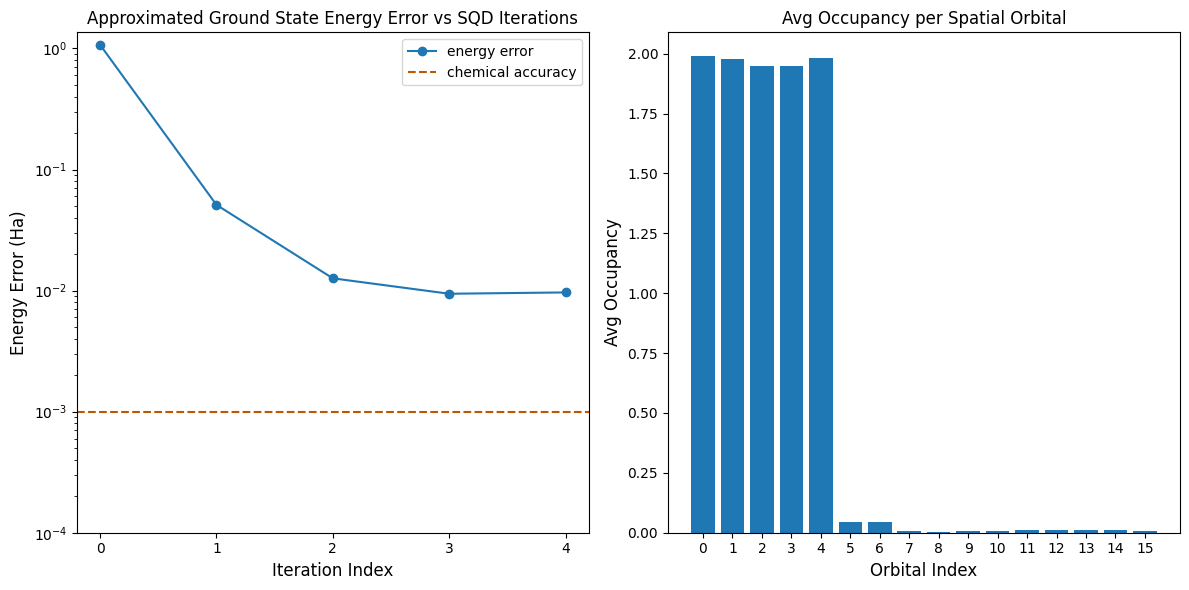

In [ ]:
import matplotlib.pyplot as plt

# エネルギープロットのデータ
x1 = range(iterations)
e_diff = [abs(np.min(energies) - exact_energy) for energies in e_hist]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# 化学的精度 (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# 平均空間軌道占有率のデータ
y2 = avg_occupancy[:num_orbitals] + avg_occupancy[num_orbitals:]
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# エネルギーのプロット
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# 軌道占有率のプロット
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Tutorial Survey

<table style="width: 100%;">
<tbody>
<tr>
<td valign="top" style="width: 10%;"><img src="https://learning-api.quantum.ibm.com/assets/53171443-b07b-4ae6-a4be-9aec32a854f5" alt="Survey" width="100%" height="100%"></td>
<td valign="top"  style="width: 80%;"><strong><a title="Tutorial Survey" href="https://your.feedback.ibm.com/jfe/form/SV_8cECHVBBWBjt72S" target="_blank">Tutorial Survey</a></strong><p><p>Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.</td>
</tr>
</tbody>
</table>
